<a href="https://colab.research.google.com/github/futartup/S8-assignment/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Add the current path to system path so that it can find the custom libraries

In [0]:
import os, sys
if '/content/drive/My Drive/Colab Notebooks/S8' not in sys.path:
  sys.path.append('/content/drive/My Drive/Colab Notebooks/S8')

# Import all the custom and inbuilt modules

In [3]:
try:
  import ipynb
except:
  !pip install ipynb --upgrade
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch.optim as optim
import os, sys

from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F



# custom apis
from ipynb.fs.full.transform_train_test_loader import *
from ipynb.fs.full.conf import *
from ipynb.fs.full.train import train_model
from ipynb.fs.full.copy_test import test_model
from ipynb.fs.full.utils import *
from ipynb.fs.full.lr_finder import *
# import gradcam 
from ipynb.fs.full.resnet_gradcam import *


  pip install torch-lr-finder -v --global-option="amp"


# The model related code. Load the model from the conf file. 

In [4]:

if custom_model['use']:
  #use custom model
  pass
elif inbuilt_model['use']:
  from ipynb.fs.full.model.pytorch_resnet import *
  from ipynb.fs.full.model.resnet import *
  from ipynb.fs.full.model.QuizDNN import *
  model_type = inbuilt_model['model']
  net = globals()[model_type]()
  #net = torchvision.models.resnet18(pretrained=False)

Current Date/Time:  2020-03-26 14:40:23.453515


# Model Summary

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Test and Train loader

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum,
                      weight_decay=0,
                      nesterov=True)

train_loader = get_train_loader()
test_loader = get_test_loader()


Files already downloaded and verified
Files already downloaded and verified


# Visualize the transformed images

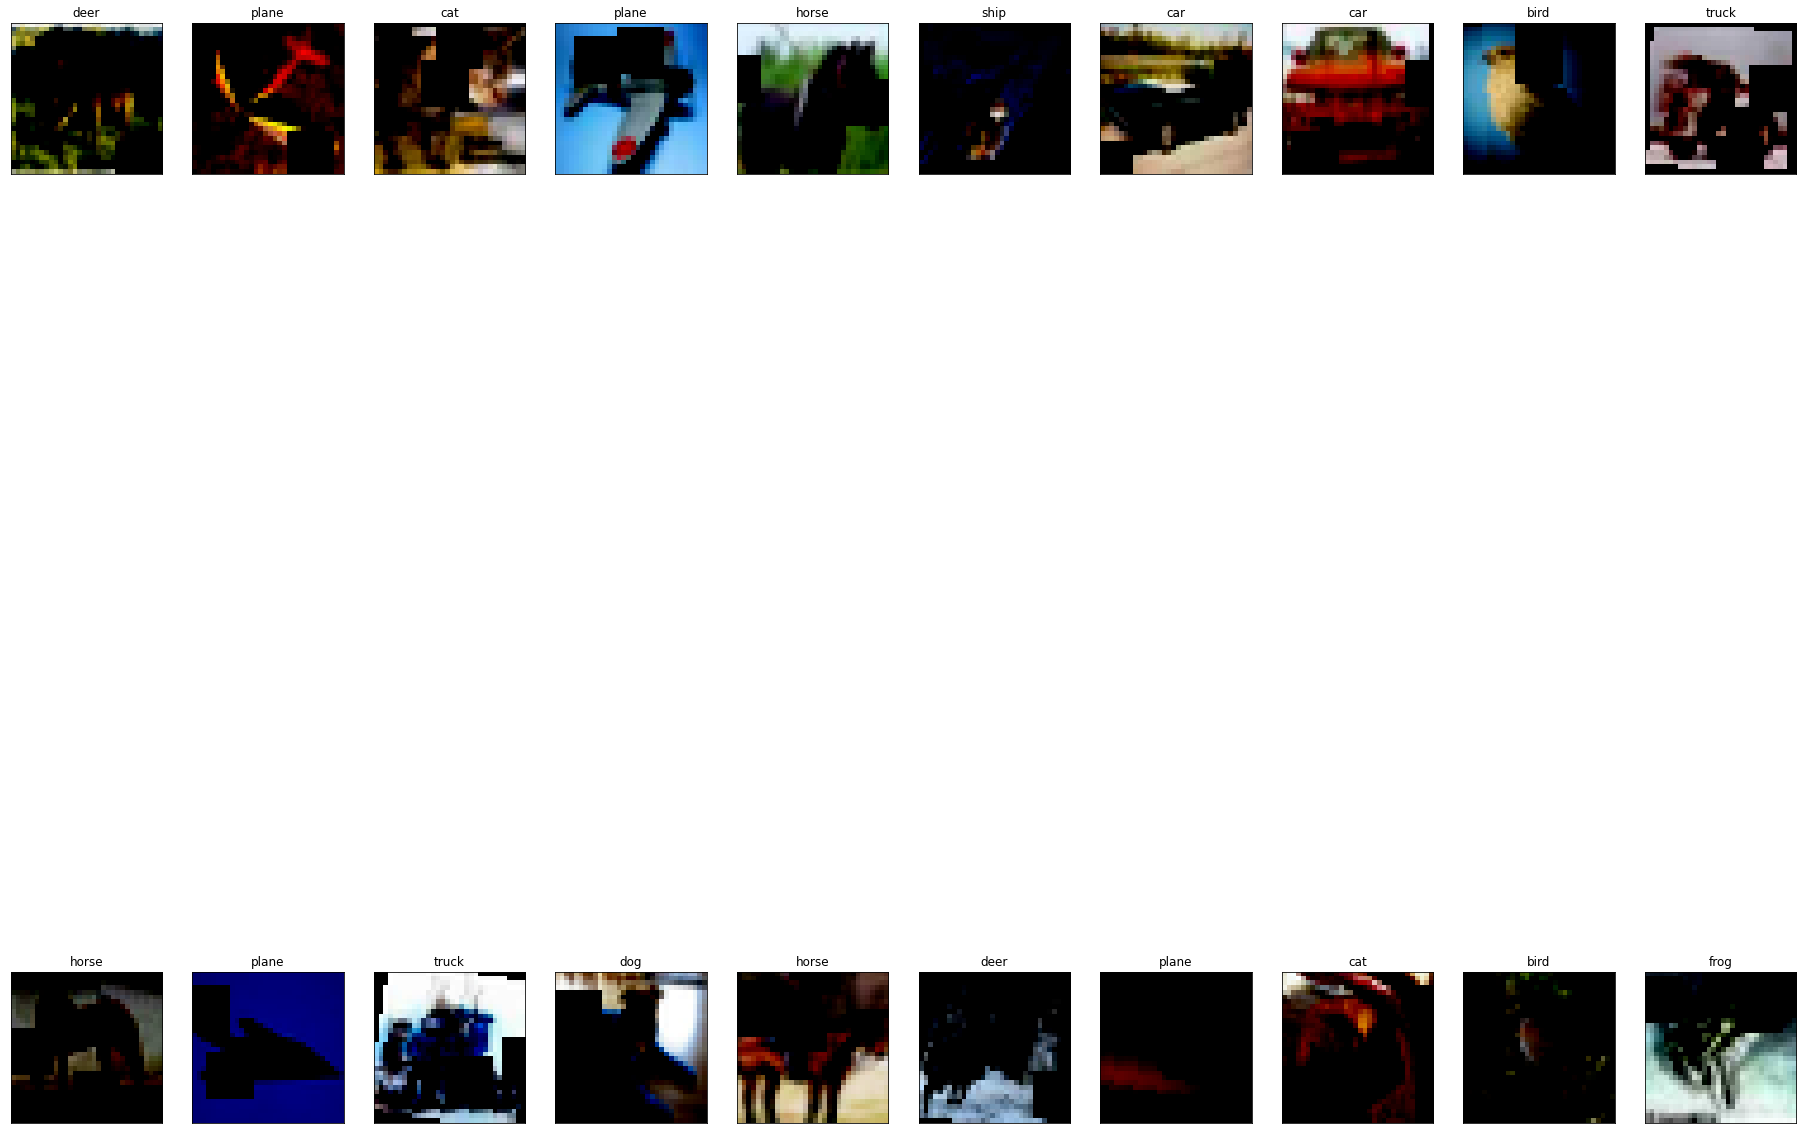

In [7]:
images, labels = next(iter(train_loader))
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(32, 32))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(images[idx].transpose((1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Find the best LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


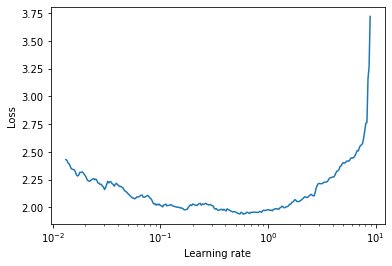

{'lr': [0.010471285480508996, 0.010715193052376065, 0.01096478196143185, 0.011220184543019634, 0.011481536214968828, 0.011748975549395295, 0.01202264434617413, 0.012302687708123816, 0.012589254117941673, 0.01288249551693134, 0.013182567385564071, 0.013489628825916535, 0.013803842646028849, 0.014125375446227544, 0.014454397707459274, 0.014791083881682075, 0.015135612484362083, 0.015488166189124814, 0.015848931924611138, 0.0162181009735893, 0.016595869074375606, 0.016982436524617443, 0.017378008287493755, 0.01778279410038923, 0.018197008586099836, 0.018620871366628676, 0.019054607179632473, 0.019498445997580452, 0.019952623149688795, 0.02041737944669529, 0.020892961308540396, 0.021379620895022322, 0.021877616239495527, 0.022387211385683396, 0.02290867652767773, 0.02344228815319922, 0.023988329190194904, 0.024547089156850305, 0.0251188643150958, 0.025703957827688636, 0.026302679918953818, 0.026915348039269156, 0.027542287033381664, 0.02818382931264454, 0.02884031503126606, 0.0295120922666

In [8]:
if use_lr_finder_train:
  lr_finder = LRFinder(model, optimizer, criterion, device) #implemented LRFinder for SGD
  lr_finder.range_test(train_loader, end_lr=100, num_iter=400, step_mode="exp")
  lr_finder.plot() # to inspect the loss-learning rate graph
  print(lr_finder.history) # see the history
  print(min(lr_finder.history['lr']))
  lr_finder.reset()

scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              factor=0.1, patience=2,
                              verbose=True)
#scheduler = StepLR(optimizer, lr_step_size, gamma=0.1)

# Test and Train

In [9]:
# Containers to plot the graph for test and train
test_losses = []
test_acc = []
train_losses = []
train_acc = []

# Containers for correctly and falsely predicted images
correct_predicted = []
false_predicted = []

# Number of images to display which are correct and false predicted
sample_count = 25

# TODO: Take the end epoch value from conf file 
for e in range(1, 50):
    print("epoch no: " , e)
    train_model(model, device, 
                train_loader, optimizer, 
                criterion, e,
                train_losses, train_acc)
    
    test_loss = test_model(model, device, 
                           test_loader, criterion, 
                           2, sample_count,
                           correct_predicted, false_predicted, 
                           test_losses, test_acc)
    scheduler.step(test_loss)
    print("===========================================================\n")



  0%|          | 0/782 [00:00<?, ?it/s]

epoch no:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=5.894765377044678 Batch_id=781 Accuracy=37.98: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 4.0531, Accuracy: 8148/50000 (16.30%)


epoch no:  2


Loss=4.54050350189209 Batch_id=781 Accuracy=42.64: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 2.0212, Accuracy: 17374/50000 (34.75%)


epoch no:  3


Loss=4.614043235778809 Batch_id=781 Accuracy=48.37: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8111, Accuracy: 22986/50000 (45.97%)


epoch no:  4


Loss=3.854948043823242 Batch_id=781 Accuracy=51.95: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8724, Accuracy: 21426/50000 (42.85%)


epoch no:  5


Loss=4.267147541046143 Batch_id=781 Accuracy=54.42: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4137, Accuracy: 25257/50000 (50.51%)


epoch no:  6


Loss=3.7445085048675537 Batch_id=781 Accuracy=56.07: 100%|██████████| 782/782 [01:12<00:00, 10.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 2.8144, Accuracy: 17380/50000 (34.76%)


epoch no:  7


Loss=3.9091620445251465 Batch_id=781 Accuracy=57.65: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 2.2632, Accuracy: 21258/50000 (42.52%)


epoch no:  8


Loss=3.453542709350586 Batch_id=781 Accuracy=59.15: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5404, Accuracy: 23913/50000 (47.83%)

Epoch     8: reducing learning rate of group 0 to 1.0000e-03.

epoch no:  9


Loss=2.678825855255127 Batch_id=781 Accuracy=66.37: 100%|██████████| 782/782 [01:12<00:00, 10.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8081, Accuracy: 35729/50000 (71.46%)


epoch no:  10


Loss=3.1490793228149414 Batch_id=781 Accuracy=67.88: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8763, Accuracy: 34514/50000 (69.03%)


epoch no:  11


Loss=2.668548822402954 Batch_id=781 Accuracy=68.34: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7243, Accuracy: 37312/50000 (74.62%)


epoch no:  12


Loss=2.7943902015686035 Batch_id=781 Accuracy=69.20: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7510, Accuracy: 36533/50000 (73.07%)


epoch no:  13


Loss=2.7085225582122803 Batch_id=781 Accuracy=69.43: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7389, Accuracy: 37196/50000 (74.39%)


epoch no:  14


Loss=3.2995033264160156 Batch_id=781 Accuracy=69.83: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7220, Accuracy: 37292/50000 (74.58%)


epoch no:  15


Loss=3.650413990020752 Batch_id=781 Accuracy=70.64: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8523, Accuracy: 34804/50000 (69.61%)


epoch no:  16


Loss=2.776768207550049 Batch_id=781 Accuracy=70.69: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7161, Accuracy: 37276/50000 (74.55%)


epoch no:  17


Loss=3.389707326889038 Batch_id=781 Accuracy=71.36: 100%|██████████| 782/782 [01:12<00:00, 10.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6945, Accuracy: 37743/50000 (75.49%)


epoch no:  18


Loss=3.276367425918579 Batch_id=781 Accuracy=71.84: 100%|██████████| 782/782 [01:12<00:00, 10.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6769, Accuracy: 38137/50000 (76.27%)


epoch no:  19


Loss=2.9546964168548584 Batch_id=781 Accuracy=72.14: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6853, Accuracy: 38115/50000 (76.23%)


epoch no:  20


Loss=3.1720938682556152 Batch_id=781 Accuracy=72.17: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7339, Accuracy: 37016/50000 (74.03%)


epoch no:  21


Loss=3.9349942207336426 Batch_id=781 Accuracy=72.34: 100%|██████████| 782/782 [01:12<00:00, 10.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8900, Accuracy: 35124/50000 (70.25%)

Epoch    21: reducing learning rate of group 0 to 1.0000e-04.

epoch no:  22


Loss=2.827650785446167 Batch_id=781 Accuracy=76.47: 100%|██████████| 782/782 [01:12<00:00, 10.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4906, Accuracy: 41595/50000 (83.19%)


epoch no:  23


Loss=3.0590360164642334 Batch_id=781 Accuracy=77.42: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4949, Accuracy: 41456/50000 (82.91%)


epoch no:  24


Loss=2.9168100357055664 Batch_id=781 Accuracy=77.64: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4637, Accuracy: 41990/50000 (83.98%)


epoch no:  25


Loss=2.2390239238739014 Batch_id=781 Accuracy=77.78: 100%|██████████| 782/782 [01:14<00:00, 10.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4627, Accuracy: 41937/50000 (83.87%)


epoch no:  26


Loss=2.5886740684509277 Batch_id=781 Accuracy=77.80: 100%|██████████| 782/782 [01:12<00:00, 10.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4535, Accuracy: 42223/50000 (84.45%)


epoch no:  27


Loss=2.89544677734375 Batch_id=781 Accuracy=78.43: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4559, Accuracy: 42073/50000 (84.15%)


epoch no:  28


Loss=2.5695459842681885 Batch_id=781 Accuracy=78.36: 100%|██████████| 782/782 [01:12<00:00, 10.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4427, Accuracy: 42434/50000 (84.87%)


epoch no:  29


Loss=2.856539487838745 Batch_id=781 Accuracy=78.48: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4398, Accuracy: 42381/50000 (84.76%)


epoch no:  30


Loss=2.2715389728546143 Batch_id=781 Accuracy=78.57: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4359, Accuracy: 42589/50000 (85.18%)


epoch no:  31


Loss=2.6670708656311035 Batch_id=781 Accuracy=78.64: 100%|██████████| 782/782 [01:12<00:00, 10.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4367, Accuracy: 42426/50000 (84.85%)


epoch no:  32


Loss=2.328521728515625 Batch_id=781 Accuracy=78.83: 100%|██████████| 782/782 [01:12<00:00, 10.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4321, Accuracy: 42560/50000 (85.12%)


epoch no:  33


Loss=2.853494167327881 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [01:12<00:00, 10.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4304, Accuracy: 42559/50000 (85.12%)


epoch no:  34


Loss=2.4929747581481934 Batch_id=781 Accuracy=78.95: 100%|██████████| 782/782 [01:12<00:00, 10.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4520, Accuracy: 42135/50000 (84.27%)


epoch no:  35


Loss=2.7225327491760254 Batch_id=781 Accuracy=79.06: 100%|██████████| 782/782 [01:12<00:00, 10.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4239, Accuracy: 42677/50000 (85.35%)


epoch no:  36


Loss=2.7985801696777344 Batch_id=781 Accuracy=79.08: 100%|██████████| 782/782 [01:12<00:00, 10.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4166, Accuracy: 42755/50000 (85.51%)


epoch no:  37


Loss=2.3170151710510254 Batch_id=781 Accuracy=79.29: 100%|██████████| 782/782 [01:12<00:00, 10.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4139, Accuracy: 42742/50000 (85.48%)


epoch no:  38


Loss=2.2486164569854736 Batch_id=781 Accuracy=79.30: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4106, Accuracy: 42927/50000 (85.85%)


epoch no:  39


Loss=2.1876184940338135 Batch_id=781 Accuracy=79.64: 100%|██████████| 782/782 [01:13<00:00, 10.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4088, Accuracy: 42993/50000 (85.99%)


epoch no:  40


Loss=2.6195931434631348 Batch_id=781 Accuracy=79.28: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4335, Accuracy: 42398/50000 (84.80%)


epoch no:  41


Loss=2.4320735931396484 Batch_id=781 Accuracy=79.55: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4004, Accuracy: 43093/50000 (86.19%)


epoch no:  42


Loss=2.4922099113464355 Batch_id=781 Accuracy=79.77: 100%|██████████| 782/782 [01:12<00:00, 10.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3950, Accuracy: 43135/50000 (86.27%)


epoch no:  43


Loss=2.366548538208008 Batch_id=781 Accuracy=79.63: 100%|██████████| 782/782 [01:12<00:00, 10.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3979, Accuracy: 43190/50000 (86.38%)


epoch no:  44


Loss=2.0366604328155518 Batch_id=781 Accuracy=80.17: 100%|██████████| 782/782 [01:13<00:00, 10.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3993, Accuracy: 43187/50000 (86.37%)


epoch no:  45


Loss=3.0029382705688477 Batch_id=781 Accuracy=80.16: 100%|██████████| 782/782 [01:13<00:00, 10.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4037, Accuracy: 43023/50000 (86.05%)

Epoch    45: reducing learning rate of group 0 to 1.0000e-05.

epoch no:  46


Loss=2.3937199115753174 Batch_id=781 Accuracy=81.28: 100%|██████████| 782/782 [01:13<00:00, 10.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3406, Accuracy: 44277/50000 (88.55%)


epoch no:  47


Loss=2.2818796634674072 Batch_id=781 Accuracy=81.65: 100%|██████████| 782/782 [01:13<00:00, 10.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3351, Accuracy: 44356/50000 (88.71%)


epoch no:  48


Loss=2.4293906688690186 Batch_id=781 Accuracy=81.80: 100%|██████████| 782/782 [01:13<00:00, 10.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3313, Accuracy: 44439/50000 (88.88%)


epoch no:  49


Loss=2.455599546432495 Batch_id=781 Accuracy=81.82: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]



Test set: Average loss: 0.3278, Accuracy: 44474/50000 (88.95%)




# *GradCam* for Resnet for falsely predicted images


truck
dog
deer
automobile
deer
bird
horse
ship
cat
deer
horse
horse
bird
truck
truck
airplane
cat
bird
deer
dog


ipynb.fs.full.resnet_gradcam:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


bird
cat
dog
deer
cat


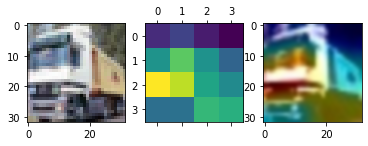

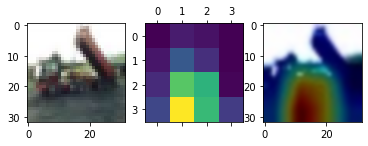

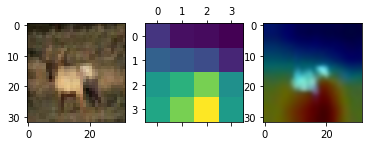

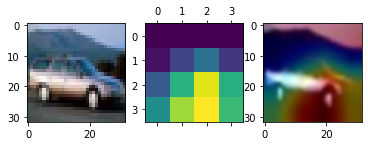

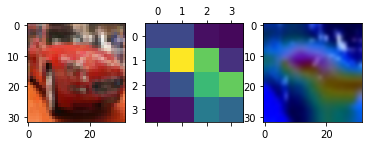

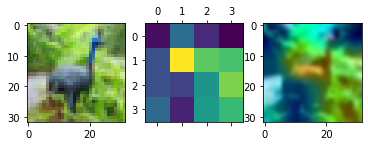

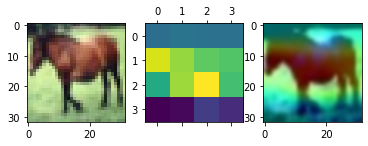

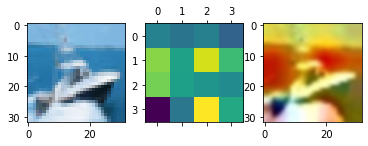

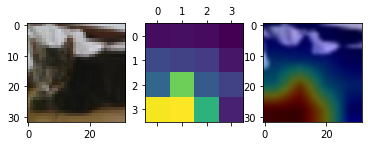

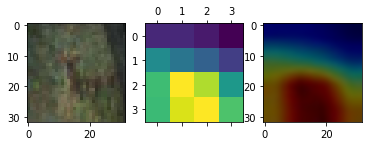

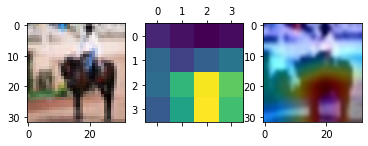

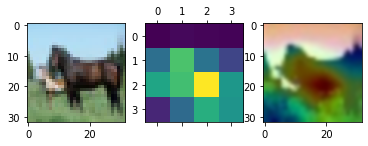

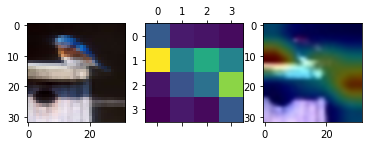

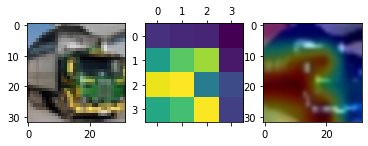

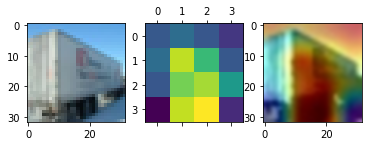

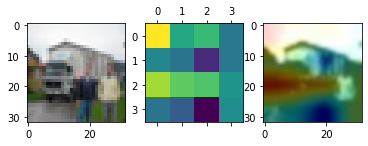

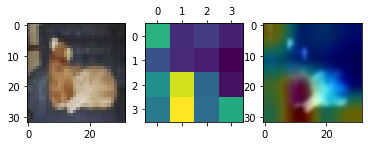

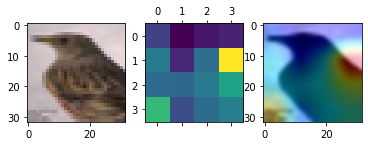

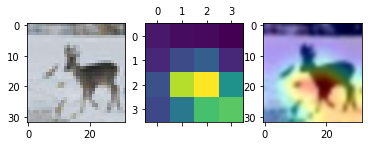

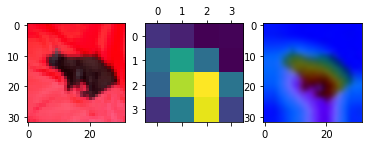

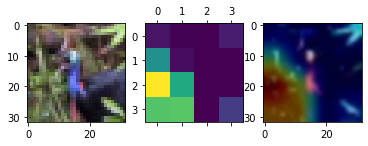

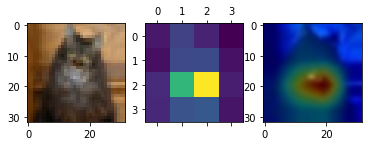

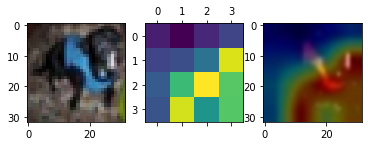

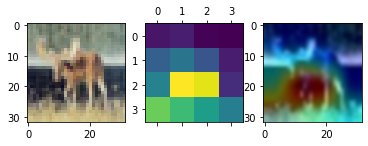

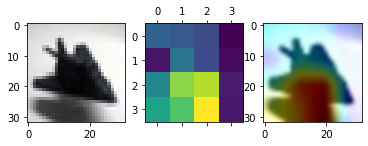

In [10]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}
images = [x['image'].unsqueeze(0) for x in false_predicted]
inputs = [i.to(device) for i in images]
gradcamof(model, inputs, classes)

# Correctly predicted images

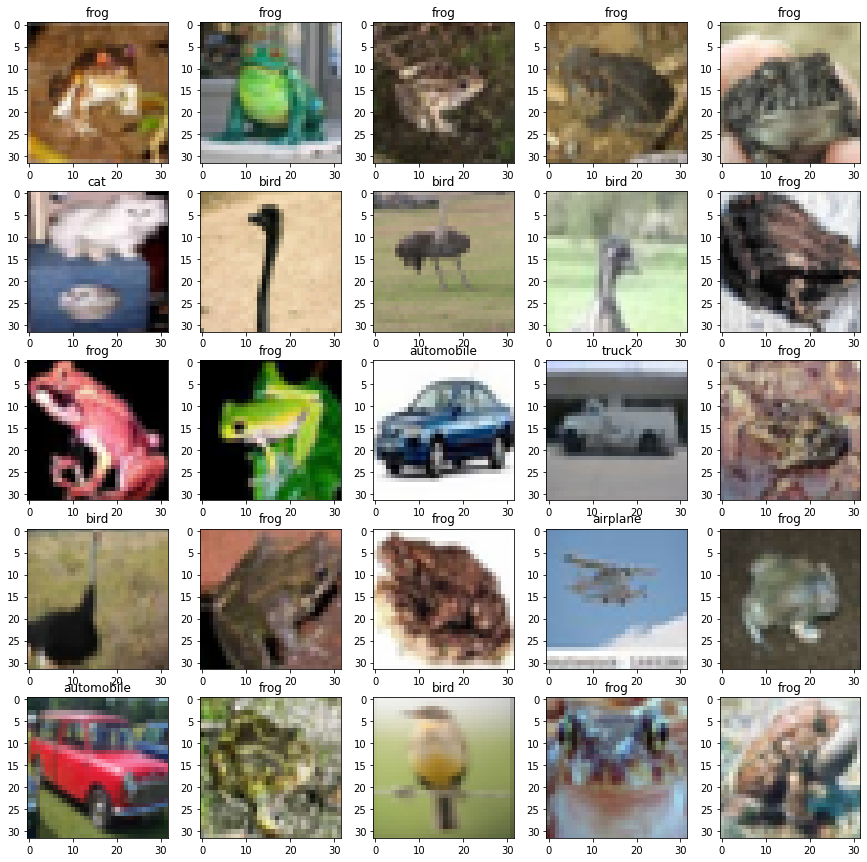

In [11]:
matplotlib_imshow(classes, correct_predicted, plt, False)

# Falsely predicted images

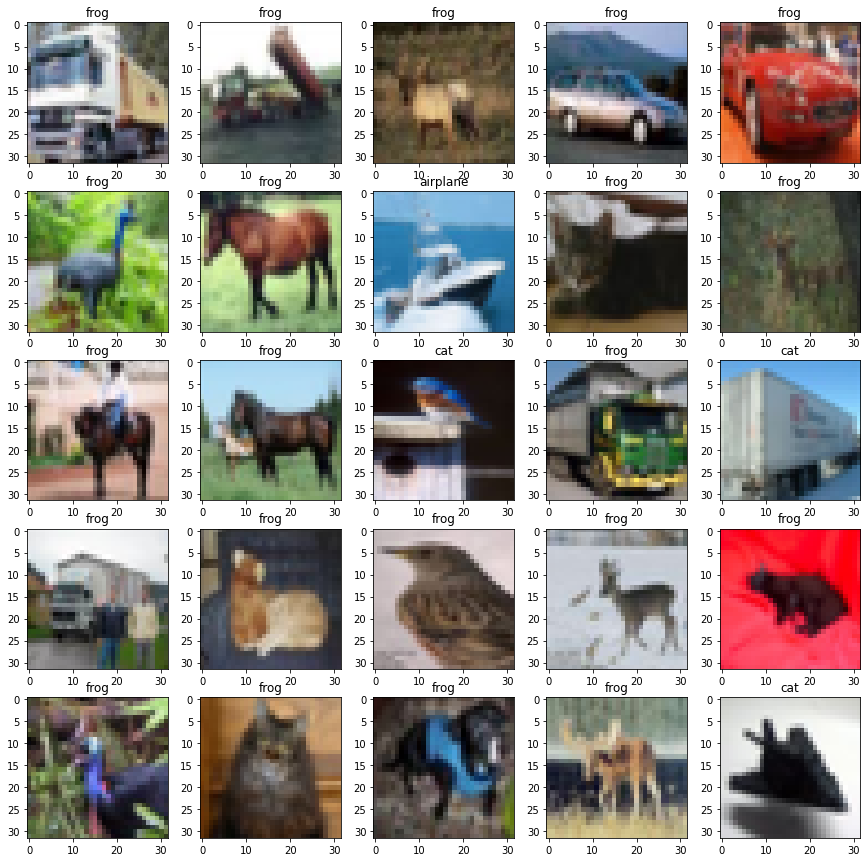

In [12]:
matplotlib_imshow(classes, false_predicted, plt, False)

# Plot The Graph for train and test 

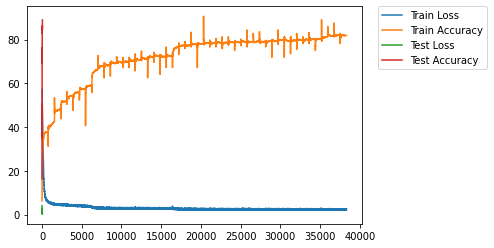

In [13]:
plottesttraingraph([x.item() for x in train_losses], train_acc, test_losses, test_acc, plt, True)